# MNL-Bandits and  Contextual-Bandit Algorithms
- Implement different algorithms about MNL-bandits and Contextual bandits from recent leteratures.
- Compare their performance by simulation data.

## Preparations

Import libraries needed.

In [2]:
import pandas as pd
import numpy as np
import random
import datetime

from scipy.optimize import minimize
import matplotlib.pyplot as plt
from gurobipy import Model, LinExpr, GRB, quicksum
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore")

import pickle

## 1. TS for MNL-Bandit
### 1.1 AAGZ-TS-Bern
AAGZ-TS-Bern: Algorithm 1 - A TS algorithm for MNL-Bandit with Independent Beta priors(K, $\alpha$, $\beta$), <html><a href='https://arxiv.org/pdf/1706.00977.pdf'>Agrawal et al(2019)</a>:<i> Thompson Sampling for the MNL-Bandit</i></html>.

- **Notation**
    - There are $i=1,2,...,N$ products/items
    - $T$:  time horizon
    - $V_i$:  # item $i$ picked 
    - $n_i$:  # epochs $i$ offered 
    - $t, l$:  times, epochs
    - $\theta_i(l)$:  prior sampling from $Beta(n_i, V_i)$ each epoch
    - $S_l$:  Assortment offered each epoch
- **Algorithm** 
    - Initialization
        - For each item $i$, $V_i=1, n_i=1$
        - $t=1$
        - $l=1$
    - **while** $t<=T$:
        - **Posterior sampling**: $\theta_i(l)$ from $Beta(n_i, V_i)$ for each $i$, compute $u_i(l)$ = $\frac{1}{\theta_i(l)}-1$, utility
        - **Subset selection**: cardinality constrained, ref <html><a href='https://pdfs.semanticscholar.org/55ab/7e27ae76ca5df4d0caef6ec14b7da8874353.pdf'>Davis et al.</a></html> (2013) <html><a href='https://www.researchgate.net/profile/David_Shmoys/publication/220244235_Dynamic_Assortment_Optimization_with_a_Multinomial_Logit_Choice_Model_and_Capacity_Constraint/links/02e7e518444fd798eb000000/Dynamic-Assortment-Optimization-with-a-Multinomial-Logit-Choice-Model-and-Capacity-Constraint.pdf'>Rusmevichientong et al.</a></html> (2008)
            - $u_i(l)$: utility in MNL, $u_i(l) = \exp(\beta*X)$, special case of D=1, X=1 of PAO-TS
            - $r_i$: revenue of each item i
        - **Epoch-based offering**: offer $S_l*$, record customer choice, $t+=1$, until no purchase
     - **Posterior update**: 
         - $\widehat{v_{i,l}}$ = sum(# $i$ picked) in this epoch
         - Update $V_i = V_i+ \widehat{v_{i,l}}, n_i += 1, l+=1$
        
    
    

##### Subset selection
Cardinality constrained, ref <html><a href='https://pdfs.semanticscholar.org/55ab/7e27ae76ca5df4d0caef6ec14b7da8874353.pdf'>Davis et al.</a></html> (2013) <html><a href='https://www.researchgate.net/profile/David_Shmoys/publication/220244235_Dynamic_Assortment_Optimization_with_a_Multinomial_Logit_Choice_Model_and_Capacity_Constraint/links/02e7e518444fd798eb000000/Dynamic-Assortment-Optimization-with-a-Multinomial-Logit-Choice-Model-and-Capacity-Constraint.pdf'>Rusmevichientong et al.</a></html> (2008)

In [7]:
# Subset selection (Optimal assortment in each epoch)
# binary search
def binary_search(reward,utility,K,N):
    r = reward
    u_i = utility
    
    UB = max(r)
    LB = max(r)*u_i[np.argmax(r)]/(1+u_i[np.argmax(r)])

    while UB-LB>0.0000001:
        z = (UB+LB)/2
        sorted_ = np.sort((r-z)*u_i)[::-1]
        pick = sorted_[sorted_>=0]
        if len(pick)>K:
            pick = pick[:K]
        if z>=sum(pick):
            UB = z
        else:
            LB = z
    return z

# Davis et al. Problem(3) when there is a simple cardinality constraint
def subset_selection_Davis1(reward,utility,K,N):
    # r, u_i with len=N instead of N+1
    r = reward
    u_i = utility
    b = K           

    m = Model('Subset Selection')
    m.setParam('OutputFlag', 0) 

    w = list()      # probability of choosing {0} or items{1,...,N}
    for i in range(N+1):
        w.append(m.addVar(lb = 0, ub = 1, name = 'w_%i' % i))

    m.addConstr(quicksum(w[i] for i in range(1,N+1))+w[0], GRB.EQUAL, 1)
    m.addConstr(quicksum(w[i]/u_i[i-1] for i in range(1,N+1)) - b*w[0], GRB.LESS_EQUAL, 0)
    for i in range(1,N+1):
        m.addConstr(w[i]/u_i[i-1], GRB.GREATER_EQUAL, 0)
        m.addConstr(w[i]/u_i[i-1] - w[0], GRB.LESS_EQUAL, 0)

    m.setObjective(quicksum(w[i]*r[i-1] for i in range(1,N+1)), GRB.MAXIMIZE)

    m.update()            
    m.optimize()
    m.ObjVal
    x = m.getVars()

    items_offered = []
    for i in range(len(x)):
        if x[i].x>0:
            items_offered.append(x[i].varname)
    
    # items in the optimal assortment S_l, index start from 1!
    items_offered = [int(name[2:]) for name in items_offered]
    if items_offered[0]==0:
        items_offered = items_offered[1:]
    
    # check items_offered
    #print('check z: ',sum([r[i-1]*u_i[i-1]/(1+sum(u_i[i-1] for i in items_offered)) for i in items_offered]))
    return items_offered 

##### AAGZ-TS-Bern: Algorithm
Algorithm 1 - A TS algorithm for MNL-Bandit with Independent Beta priors(K, $\alpha$, $\beta$), <html><a href='https://arxiv.org/pdf/1706.00977.pdf'>Agrawal et al(2019)</a></html>.


In [8]:
def AAGZ_Bern(N,T,K,r,v0,v):
    
# Initialize
    t = 1      
    l = 1  
    n_i = np.array([1 for i in range(N)])
    V_i = np.array([1 for i in range(N)]) 
    epochs = []         # times for each epoch
    R = 0               # Empirical Reward


# Algorithm    
    while t<=T:
        # Posterior Sampling
        theta_i = np.array([np.random.beta(n_i[i],V_i[i]) for i in range(N)])
        u_i = 1/theta_i - 1

        # Subset Selection, inde start from 1!
        items_offered = subset_selection_Davis1(r, u_i, K, N)

        # Epoch-based offering
        ## add 0 (no purchase)
        items_list = np.insert(np.array(items_offered),0,0) 
        ## True choice probability
        v_l = np.array([v[i-1] for i in items_offered])
        choice_prob = v_l/(v0+sum(v_l))
        choice_prob_with0 = np.insert(choice_prob, 0, 1-sum(choice_prob))
        ## offer until no purchase
        c_l = []
        while True:
            c = np.random.choice(a = items_list, p = choice_prob_with0)
            if c != 0:
                R += r[c-1]
                c_l.append(c)
                t += 1
            else: 
                R += 0
                c_l.append(c)
                t += 1
                break
        epochs.append(t)

        # Posterior updates
        items_picked, times_picked = np.unique(c_l[:-1], return_counts=True)
        for i in range(len(items_picked)):
            V_i[items_picked[i] -1] += times_picked[i]

        for i in items_offered:
            n_i[i-1] += 1

        # print(l,t,n_i[0],V_i[0],items_offered)
        l+=1
        
    #print('T =',T,'t =',t)
# Optimal Reward
    optimal_items_offered = subset_selection_Davis1(r,v,K,N)
    optimal_items_r = np.array([r[i-1] for i in optimal_items_offered])
    optimal_items_u = np.array([v[i-1] for i in optimal_items_offered])

    E_reward = sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
    Optimal_reward = E_reward*t    # t might exceed T 
    
    regret = Optimal_reward-R
    
    return regret

### 1.2 AAGZ-TS-Gauss

AAGZ-TS-Gauss: Algorithm 2 - A TS algorithm for MNL-Bandit with Gaussian approximation and correlated sampling  <html><a href='https://arxiv.org/pdf/1706.00977.pdf'>Agrawal et al(2019)</a></html>.

- **The differences from AAGZ-TS-Bern**
    - **Initialization**
        - Offer single item until nopurchase to get initial $V_i$, $n_i$.
    - **Multiple Sampling**
        - K samples of utility $u_i(l)$ for each item
    - **Correlated Sampling**
        - When doing each sampling out of K, use a standard normal sample $\theta$
        - Compute $$u_i^j(l) = \widehat{v_i} + \theta^j(l) * (\sqrt{\frac{50\widehat{v_i}(\widehat{v_i}+1)}{n_i}} + \frac{75\sqrt{logTK}}{n_i})$$
          where $j = 1,2,...,K$
        - Use the most optimistic sample of utility $u_i(l) = \max_{j=1,...,K} {u_i^j(l)}$

##### AAGZ-TS-Gauss: Algorithm

In [9]:
def AAGZ_Gauss(N,T,K,r,v0,v):
    
# Initialize
    t = 0      
    l = 0  
    n_i = np.array([0 for i in range(N)])
    V_i = np.array([0 for i in range(N)]) 
    epochs = []         # times for each epoch
    R = 0               # Empirical Reward
    
    vi_hat = np.array([0 for i in range(N)])  # vi_hat = Vi/ni
    
    for i in range(1,N+1):
        display = [0,i]
        choice_p = [v0/(v0+v[i-1]), v[i-1]/(v0+v[i-1])]
        times_offeri = 0
        while True:
            choice_ = np.random.choice(a = display, p = choice_p)
            times_offeri += 1
            if choice_!= 0:
                pass
            else:
                break
        V_i[i-1] += times_offeri-1
        n_i[i-1] += 1
        t += times_offeri
        epochs.append(t)
        l += 1
    #print(l)
                
# Algorithm    
    while t<=T:   
        # Update vi_hat
        vi_hat = V_i/n_i
        
        # Multiple Sampling: K samples of utility for each item i=1,...,N
        u_ij = np.array([[0.0 for j in range(K)] for i in range(N)])
        
        # Correlated Sampling
        for j in range(K):
            theta = np.random.normal(0,1)
            #u_ij[:,j] = vi_hat + theta*(np.sqrt(50*vi_hat*(vi_hat+1)/n_i) + 75*np.sqrt(np.log(T*K))/n_i)
            #the upper bound is too big
            u_ij[:,j] = vi_hat + theta*(np.sqrt(vi_hat*(vi_hat+1)/n_i) + np.sqrt(np.log(T*K))/n_i)
        
        u_i = np.max(u_ij, axis=1)
        u_i[np.where(u_i==0)] = 1e-9    # u_i is a divisor in subset_selection_Davis1() so it cannot be 0
        
        # Subset Selection, inde start from 1!
        items_offered = subset_selection_Davis1(r, u_i, K, N)
        
        # Epoch-based offering
        ## add 0 (no purchase)
        items_list = np.insert(np.array(items_offered),0,0) 
        ## True choice probability
        v_l = np.array([v[i-1] for i in items_offered])
        choice_prob = v_l/(v0+sum(v_l))
        choice_prob_with0 = np.insert(choice_prob, 0, 1-sum(choice_prob))
        ## offer until no purchase
        c_l = []
        while True:
            c = np.random.choice(a = items_list, p = choice_prob_with0)
            if c != 0:
                R += r[c-1]
                c_l.append(c)
                t += 1
            else: 
                R += 0
                c_l.append(c)
                t += 1
                break
        epochs.append(t)
              
        # Posterior updates
        items_picked, times_picked = np.unique(c_l[:-1], return_counts=True)
        for i in range(len(items_picked)):
            V_i[items_picked[i] -1] += times_picked[i]

        for i in items_offered:
            n_i[i-1] += 1

        # print(l,t,n_i[0],V_i[0],items_offered)
        l+=1

    #print('T =',T,'t =',t)
# Optimal Reward
    optimal_items_offered = subset_selection_Davis1(r,v,K,N)
    optimal_items_r = np.array([r[i-1] for i in optimal_items_offered])
    optimal_items_u = np.array([v[i-1] for i in optimal_items_offered])

    E_reward = sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
    Optimal_reward = E_reward*t    # t might exceed T 
    
    regret = Optimal_reward-R
    
    return regret

### 1.3 Simulation: AAGZ-TS-Bern & Gauss
- T = 200000 (50 instances with different T: from 0 to 200000)
- N = 1000
- K = 10

Calculate total regrets for each instance.

The total regrest each time is the average total regret of 5 simulations.

#### Simulation1: T=200000, K=10, N=1000

In [10]:
# Setting
N = 1000
#T = 2000 
K = 10
r = np.random.random(N)
# Customer choice model: MNL (True utility)
v0 = 1
v = np.random.uniform(0,1,N)

In [11]:
#with open('r_v_setting0703.pkl', 'wb') as f:
   # pickle.dump([r, v], f)
    
with open('r_v_setting0703.pkl', 'rb') as f: 
    r, v = pickle.load(f)

In [12]:
T1s = np.arange(0,160000,4000)
T2s = np.arange(160000,204000,4000)

In [ ]:
Regrets_beta1 = [np.mean([AAGZ_Bern(N,T,K,r,v0,v) for i in range(5)]) for T in T1s]

In [ ]:
t1 = datetime.datetime.now().hour
Regrets_beta2 = [np.mean([AAGZ_Bern(N,T,K,r,v0,v) for i in range(5)]) for T in T2s]
t2 = datetime.datetime.now().hour
print(f'Running time: about {t2-t1} hours')

In [ ]:
t3 = datetime.datetime.now().hour
Regrets_gauss1 = [np.mean([AAGZ_Gauss(N,T,K,r,v0,v) for i in range(5)]) for T in T1s]
t4 = datetime.datetime.now().hour
print(f'Running time: about {t4-t3} hours')

In [ ]:
t5 = datetime.datetime.now().hour
Regrets_gauss2 = [np.mean([AAGZ_Gauss(N,T,K,r,v0,v) for i in range(5)]) for T in T2s]
t6 = datetime.datetime.now().hour
print(f'Running time: about {t6-t5} hours')

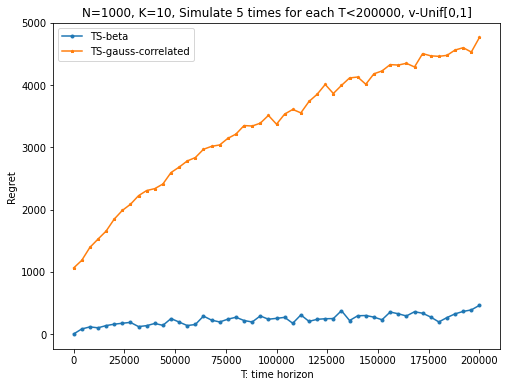

In [61]:
with open('regrets_beta0710_200000T.pkl', 'rb') as f: 
    Regrets_beta1 = pickle.load(f)
with open('regrets_gauss0712_200000T.pkl', 'rb') as f: 
    Regrets_gauss1 =  pickle.load(f)
Ts = np.arange(0,204000,4000)

plt.figure(figsize=(8,6))
plt.plot(Ts, Regrets_beta1, marker='o', markersize=3, label='TS-beta')
plt.plot(Ts, Regrets_gauss1, marker='*', markersize=3, label='TS-gauss-correlated')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.title('N=1000, K=10, Simulate 5 times for each T<200000, v-Unif[0,1]')
plt.legend()
plt.show()

In [ ]:
with open('regrets_beta0710_200000T.pkl', 'wb') as f:
    pickle.dump(Regrets_beta1, f)

In [ ]:
with open('regrets_gauss0712_200000T.pkl', 'wb') as f:
    pickle.dump(Regrets_gauss1, f)

#### Simulation2: T=15000, K=20, N=80

In [6]:
# Setting
N = 80
K = 20
r1 = np.random.random(N)
# Customer choice model: MNL (True utility)
v0 = 1
v1 = np.random.uniform(0,1,N)

In [7]:
#with open('r_v_setting0712.pkl', 'wb') as f:
#    pickle.dump([r1, v1], f)

with open('r_v_setting0712.pkl', 'rb') as f: 
    r1, v1 = pickle.load(f)

T2 = np.arange(0,15500,500)

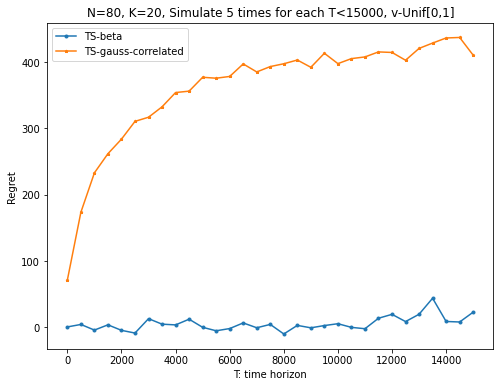

In [64]:
#Regrets_beta3 = [np.mean([AAGZ_Bern(N,T,K,r1,v0,v1) for i in range(5)]) for T in T2]
#Regrets_gauss3 = [np.mean([AAGZ_Gauss(N,T,K,r1,v0,v1) for i in range(5)]) for T in T2]

plt.figure(figsize=(8,6))
plt.plot(T2, Regrets_beta3, marker='o', markersize=3, label='TS-beta')
plt.plot(T2, Regrets_gauss3, marker='*', markersize=3, label='TS-gauss-correlated')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.legend()
plt.title('N=80, K=20, Simulate 5 times for each T<15000, v-Unif[0,1]')
plt.show()

In [28]:
with open('regrets_beta0712_80N.pkl', 'wb') as f:
    pickle.dump(Regrets_beta3, f)

with open('regrets_gauss0712_80NT.pkl', 'wb') as f:
    pickle.dump(Regrets_gauss3, f)

#### Simulation3: T=15000, K=20, N=150

In [37]:
N = 150
K = 20
r2 = np.random.random(N)
# Customer choice model: MNL (True utility)
v0 = 1
v2 = np.random.uniform(0,1,N)
T2 = np.arange(0,15500,500)

In [40]:
#with open('r2_v2_setting0712.pkl', 'wb') as f:
#    pickle.dump([r2, v2], f)

with open('r2_v2_setting0712.pkl', 'rb') as f: 
    r2, v2 = pickle.load(f)

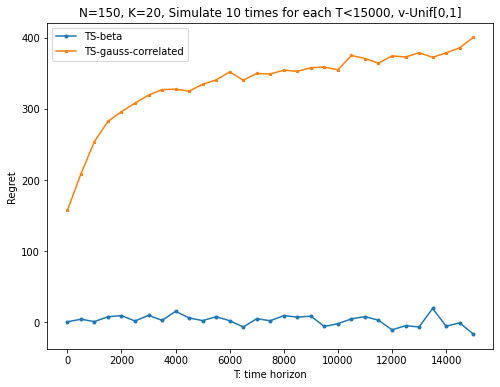

In [65]:
#Regrets_beta4 = [np.mean([AAGZ_Bern(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
#Regrets_gauss4 = [np.mean([AAGZ_Gauss(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
plt.figure(figsize=(8,6))
plt.plot(T2, Regrets_beta4, marker='o', markersize=3, label='TS-beta')
plt.plot(T2, Regrets_gauss4, marker='*', markersize=3, label='TS-gauss-correlated')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.legend()
plt.title('N=150, K=20, Simulate 10 times for each T<15000, v-Unif[0,1]')
plt.show()

In [43]:
with open('regrets_beta0712_150N.pkl', 'wb') as f:
    pickle.dump(Regrets_beta4, f)

with open('regrets_gauss0712_150N.pkl', 'wb') as f:
    pickle.dump(Regrets_gauss4, f)

#### Simulation4: T=15000, K=20, N=80, using smaller upper bound in Gaussian (75 --> 25)

Using license file /Users/fanxiuqi/gurobi.lic
Academic license - for non-commercial use only


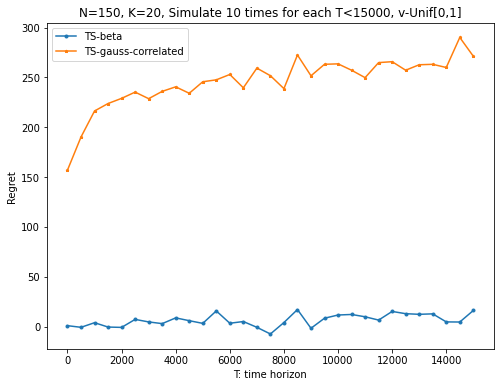

In [13]:
N = 150
K = 20
r2 = np.random.random(N)
# Customer choice model: MNL (True utility)
v0 = 1
v2 = np.random.uniform(0,1,N)
T2 = np.arange(0,15500,500)

with open('r2_v2_setting0712.pkl', 'rb') as f: 
    r2, v2 = pickle.load(f)

Regrets_beta5 = [np.mean([AAGZ_Bern(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
Regrets_gauss5 = [np.mean([AAGZ_Gauss(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
plt.figure(figsize=(8,6))
plt.plot(T2, Regrets_beta5, marker='o', markersize=3, label='TS-beta')
plt.plot(T2, Regrets_gauss5, marker='*', markersize=3, label='TS-gauss-correlated')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.legend()
plt.title('N=150, K=20, Simulate 10 times for each T<15000, v-Unif[0,1]')
plt.show()

In [16]:
with open('regrets_beta0727_25.pkl', 'wb') as f:
    pickle.dump(Regrets_beta5, f)

with open('regrets_gauss0727_25.pkl', 'wb') as f:
    pickle.dump(Regrets_gauss5, f)

#### Simulation5: T=15000, K=20, N=80, using smaller upper bound in Gaussian (75-->1)

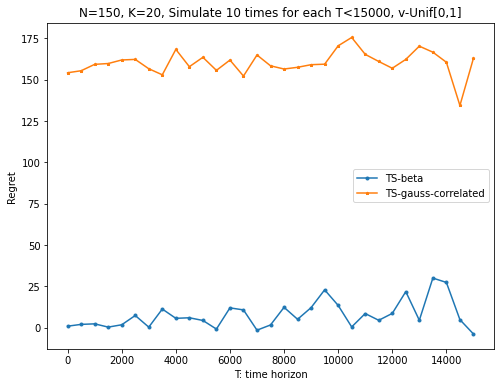

In [19]:
N = 150
K = 20
r2 = np.random.random(N)
# Customer choice model: MNL (True utility)
v0 = 1
v2 = np.random.uniform(0,1,N)
T2 = np.arange(0,15500,500)

with open('r2_v2_setting0712.pkl', 'rb') as f: 
    r2, v2 = pickle.load(f)

Regrets_beta6 = [np.mean([AAGZ_Bern(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
Regrets_gauss6 = [np.mean([AAGZ_Gauss(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
plt.figure(figsize=(8,6))
plt.plot(T2, Regrets_beta6, marker='o', markersize=3, label='TS-beta')
plt.plot(T2, Regrets_gauss6, marker='*', markersize=3, label='TS-gauss-correlated')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.legend()
plt.title('N=150, K=20, Simulate 10 times for each T<15000, v-Unif[0,1]')
plt.show()

In [20]:
with open('regrets_beta0727_1.pkl', 'wb') as f:
    pickle.dump(Regrets_beta6, f)

with open('regrets_gauss0727_1.pkl', 'wb') as f:
    pickle.dump(Regrets_gauss6, f)

#### Simulation6: T=15000, K=20, N=80, using smaller upper bound in Gaussian (75-->1， 50-->1)

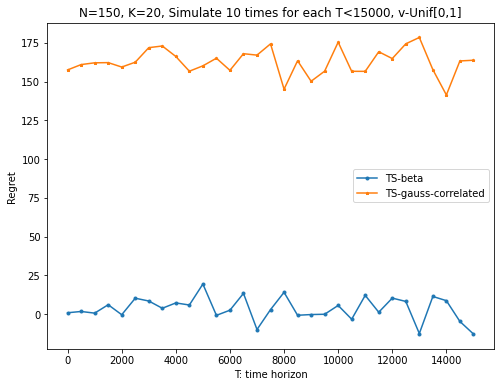

In [21]:
N = 150
K = 20
r2 = np.random.random(N)
# Customer choice model: MNL (True utility)
v0 = 1
v2 = np.random.uniform(0,1,N)
T2 = np.arange(0,15500,500)

with open('r2_v2_setting0712.pkl', 'rb') as f: 
    r2, v2 = pickle.load(f)

Regrets_beta7 = [np.mean([AAGZ_Bern(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
Regrets_gauss7 = [np.mean([AAGZ_Gauss(N,T,K,r2,v0,v2) for i in range(10)]) for T in T2]
plt.figure(figsize=(8,6))
plt.plot(T2, Regrets_beta7, marker='o', markersize=3, label='TS-beta')
plt.plot(T2, Regrets_gauss7, marker='*', markersize=3, label='TS-gauss-correlated')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.legend()
plt.title('N=150, K=20, Simulate 10 times for each T<15000, v-Unif[0,1]')
plt.show()

In [22]:
with open('regrets_beta0727_1_1.pkl', 'wb') as f:
    pickle.dump(Regrets_beta7, f)

with open('regrets_gauss0727_1_1.pkl', 'wb') as f:
    pickle.dump(Regrets_gauss7, f)

## 2. Contextual Bandit: TS-MNL with Optimistic Sampling

### 2.1 Contextual Bandit: TS-MNL

TS-MNL: Algorithm 1 - TS-MNL
<html><a href='http://www.columbia.edu/~va2297/mnl_bandit_TS.pdf'>Min-hwan Oh(2019)</a>:<i> Thompson Sampling for Multinomial Logit Contextual Bandit</i></html>.

- **Notation**
    - There are $i=1,2,...,N$ products/items
    - $T$: time horizon
    - $x_{ti}, r_{ti}$: in period $t$, feature vector $x$, reward $r$ of product $i$
    - $\theta^*$: time-invariant coefficient vector, unknown
    - **$Q_0$: prior distribution of $\theta$**
        - $$R_t(S_t,\theta^*) = \sum_{i\in{S_t}}{\frac{ r_{ti}exp({x_{ti}^T\theta^*})}{1+\sum_{j\in{S_t}}{exp({x_{tj}^T\theta^*})}}}$$      
    - $V_i$:  # item $i$ picked, $V_i = exp({x_{ti}^T\theta^*})$
    - $n_i$:  # epochs $i$ offered 
    - $t, l$:  times, epochs
    - $\theta_i(l)$:  prior sampling from $Beta(n_i, V_i)$ each epoch
    - $S_l$:  Assortment offered each epoch
- **Algorithm** 
    - **Input**
        - prior distribution $Q_0$
    - **while** $t<=T$:
        - Observe $x_{ti}, r_{ti}$ for all $i \in[N]$
        - **Posterior sampling**: sample $\widehat{\theta_t}$ from posterior distribution $Q_t$
        - **Subset selection**: $S_t = argmax_S R_t(S,\widehat{\theta_t})$
        - **Epoch-based offering**: offer $S_l*$, record customer choice, $t+=1$, until no purchase
        - Offer $S_t$, observe choice $y_t$.
        
####  TS-MNL 
- **Setting**
    - Customer preference
        - True $\theta^*$ = [0.32, 0.5, 0.28, -0.1, 0.11, 0.3, 0.15, 0.2, 0.4, -0.2]
        - $d$ = 10
    - Problem 
        - Prior distribution $Q_0 ~ N(\vec{0},1)$
        - Features and rewards $x_{ti}, r_{ti}$
            - For $i=1,...,N$: $x_{0i} ~ Unif[0,1]$ for each $d \in D$
            - In $t=1,...,T$:
                - $x_{ti} = x_{t-1,i}$, wp 1/2
                - $x_{ti} = x_{t-1,i} + 0.05$, wp 1/3
                - $x_{ti} = x_{t-1,i} - 0.05$, wp 1/3
                - $x_{ti} \in[0,1]$ 
            - $r_{ti} = x_{ti}[-1]$, the last feature is reward


In [1]:
def posterior_sample_theta(mus,stds,observations,size,Xit):
    model = pm.Model()
    with model:
        mu = mus                                  # Vector of means
        cov = np.zeros((D,D))
        for i in range(D):
            cov[i][i]=stds[i]
        
        thetas = pm.MvNormal('thetas', mu=mu, cov=cov, shape=D)

        Vj = pm.math.exp(pm.math.dot(Xit,thetas))     # utility for product j
        V = 1 + pm.math.sum(Vj)                       # sum of utility, the denominator, starting with the utility of not buying
        Vit = pm.math.concatenate([[1],Vj])           # utility of no purchase = 1

        choice_prob_it = Vit/V

        choice_Y = pm.Multinomial('Customer Choice',n=1, p=choice_prob_it, observed = observations)

    with model:
        step = pm.NUTS()#########33
        trace = pm.sample(size, step=step)

    updated_thetas_mu = pm.summary(trace)['mean'].values############
    updated_thetas_std = pm.summary(trace)['sd'].values
    
    return updated_thetas_mu, updated_thetas_std, trace

In [ ]:
D = 10
N = 150
K = 8
T = np.arange(0,15500,500)
np.random.seed(801)
Xit = np.random.uniform(0,1,size=(N,D))      # X0t
true_theta = [0.32, 0.5, 0.28, -0.1, 0.11,0.3, 0.15, 0.2, 0.4, -0.2]   
posterior_size = 10

In [10]:
#with open('Context_setting_0728.pkl', 'wb') as f:
#    pickle.dump([Xit,true_theta],f)

with open('Context_setting_0728.pkl', 'rb') as f:
    Xit, true_theta = pickle.load(f)

In [13]:
def Contextal_TS_MNL(D,K,N,T,Xit,true_theta):
    rit = Xit[:,-1] 
    mus = [1 for i in range(10)]                 # theta_0: N(1,1)
    stds = [1 for i in range(10)]                # mu=1, cov=0, stds=1
    v0 = 1
    v = np.exp(np.dot(Xit,mus))                  # initial utitlity, j=1, j=2, ... , j=150
    t = 0
    R = 0
    Optimal_R = 0

    initial_choice = [0 for i in range(151)]     # choice set, len=N+1
    initial_choice[0] = 1
    observations = [initial_choice]
    
    #theta_mu_track = [mus]

    while t<=T:

        # Posterior sampling
        if t==0:
            mus, stds, trace = posterior_sample_theta(mus, stds, observations, posterior_size, Xit)  
        else:
            wp = np.random.rand()                    # time-changing features
            if wp < 0.5:
                pass
            elif 0.5<= wp <0.83:
                Xit += 0.05
            else:
                Xit -= 0.05 
            rit = Xit[:,-1]                           # Observe features and rewards
                                                      # Posterior sampling
            mus, stds, trace = posterior_sample_theta(mus, stds, observations, posterior_size, Xit)  

        # Assortment subset selection
        v = np.exp(np.dot(Xit,mus))                   # utility for this period t
        items_offered = subset_selection_Davis1(rit, v, K, N)       # items out of N
        items_list = np.insert(np.array(items_offered),0,0)         # items including no-purchase 0, len=N+1

        # Observe customer choice
        Xit_t = np.array([Xit[i-1] for i in items_offered])         # true v: choice probability for items showed
        true_v = np.exp(np.dot(Xit_t, true_theta)) 
        true_v = np.insert(true_v,0,v0)
        true_choice_prob = true_v/sum(true_v)

        true_choice_t = np.random.multinomial(1,true_choice_prob)   # len<=K, display
        choice_item = items_list[np.where(true_choice_t==1)[0][0]]
        choice_t = [0 for i in range(151)]
        choice_t[choice_item] = 1
        observations.append(choice_t)

        # Update reward
        if choice_item==0:
            R += 0
        else:
            R += rit[choice_item - 1]

        # Optimal reward:  instead of computing avg, calculate each time as features are changing
        optimal_v  = np.exp(np.dot(Xit, true_theta))                # optimal v: choice probability for all N items
        optimal_offered = subset_selection_Davis1(rit, optimal_v, K, N)
        optimal_list = np.insert(np.array(optimal_offered),0,0)

        optimal_Xit_t = np.array([Xit[i-1] for i in optimal_offered])
        optimal_true_v = np.exp(np.dot(optimal_Xit_t, true_theta)) 
        optimal_true_v = np.insert(optimal_true_v,0,v0)

        optimal_choice_prob = optimal_true_v/sum(optimal_true_v)
        optimal_choice = np.random.multinomial(1,optimal_choice_prob)

        optimal_choice_item = optimal_list[np.where(optimal_choice==1)[0][0]]

        # Update Optimal reward
        if optimal_choice_item==0:
            Optimal_R += 0
        else:
            Optimal_R += rit[optimal_choice_item - 1]
        
        #theta_mu_track.append(mus)
        t += 1 
        print(t)
        
        reg = Optimal_R-R
        with open(f'TSMNL_regrets/TSMNL_regret_T{t}_0802.pkl', 'wb') as f:
            pickle.dump(reg,f)

    
    regret = Optimal_R-R
    
    with open(f'TSMNL_regrets/theta_mu_track_T{T}.pkl', 'wb') as f:
            pickle.dump(theta_mu_track_T,f)
        
    return regret#,theta_mu_track

In [1]:
Regrets_beta8 = [np.mean([Contextal_TS_MNL(D,K,N,t,Xit,true_theta) for i in range(10)]) for t in T]
plt.figure(figsize=(8,6))
plt.plot(T, Regrets_beta8, marker='o', markersize=3, label='TS-MNL-Context')
plt.xlabel('T: time horizon')
plt.ylabel('Regret')
plt.legend()
plt.title('N=150, K=20, D=20, Simulate 10 times for each T<15000')
plt.show()

"Regrets_beta8 = [np.mean([Contextal_TS_MNL(D,K,N,t,Xit,true_theta) for i in range(10)]) for t in T]\nplt.figure(figsize=(8,6))\nplt.plot(T, Regrets_beta8, marker='o', markersize=3, label='TS-MNL-Context')\nplt.xlabel('T: time horizon')\nplt.ylabel('Regret')\nplt.legend()\nplt.title('N=150, K=20, D=20, Simulate 10 times for each T<15000')\nplt.show()"

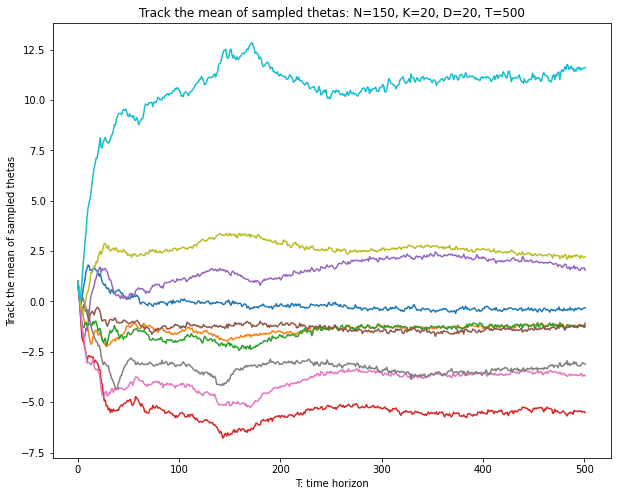

In [20]:
with open('theta_mu_track_0728.pkl', 'rb') as f:
    theta_mu_track = pickle.load(f)
    
plt.figure(figsize=(10,8))
plt.plot(theta_mu_track)
plt.xlabel('T: time horizon')
plt.ylabel('Track the mean of sampled thetas')
plt.title('Track the mean of sampled thetas: N=150, K=20, D=20, T=500')
plt.show()

## Appendix

### Code
#### AAGZ-Bern

#### Try MCMC with NUTS

In [71]:
# try: mcmc with NUTS

temp_m = pm.Model()
with temp_m:
    cov = np.array([[1., 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    mu = np.zeros(3)
    vals = pm.MvNormal('vals', mu=mu, cov=cov, shape=3)  # multivariate normal: feature coefficient 
    
    
    # features x1, x2, x3 = 1,1,1
    V0 = 1
    V1 = pm.math.exp(vals[0])
    V2 = pm.math.exp(vals[1])
    V3 = pm.math.exp(vals[2])
    V = 1 + V1 + V2 + V3
    
    Y = pm.Multinomial('temp', n=1, p=[V0/V, V1/V, V2/V, V3/V], observed = [[0,1,0,0],[0,1,0,0],[0,1,0,0]])

for RV in temp_m.basic_RVs:
    print(RV.name, RV.logp(temp_m.test_point))
print(temp_m.logp(temp_m.test_point))

with temp_m:
    step = pm.NUTS()
    trace = pm.sample(100, step=step)

pm.summary(trace)

vals -2.756815599614018
temp -4.1588830833596715
-6.915698682973689


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vals]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 3 seconds.
/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
vals[0],1.180,0.753,-0.139,2.694,0.056,0.042,180.0,161.0,176.0,115.0,1.01
vals[1],-0.387,0.932,-2.080,1.316,0.061,0.064,234.0,107.0,234.0,118.0,1.03
vals[2],-0.405,0.931,-2.095,1.250,0.062,0.049,225.0,180.0,228.0,181.0,1.00


#### Math operations in PyMC3

<html> <p>PyMC3 math <a href="https://docs.pymc.io/api/math.html">operations</a></p></html>

In [9]:
vals

vals

In [10]:
x = np.array([1,2,3])
pm.math.dot(x,vals)
outxx = pm.math.dot(x,vals)

outxx.eval(({vals:[1,1,1]}))

array(6.)

In [33]:
x = [[1,1,1],[2,2,2],[3,3,3]]
t = pm.math.dot(x,vals)
t1 = pm.math.exp(pm.math.dot(x,vals))
t2 = pm.math.sum(t)
t3 = pm.math.concatenate([[0],t])
t4 = t/t2

print(t.eval({vals:[1,1,1]}))
print(t1.eval({vals:[1,1,1]}))
print(t2.eval({vals:[1,1,1]}))
print(t3.eval({vals:[1,1,1]}))
print(t4.eval({vals:[1,1,1]}))

[3. 6. 9.]
[  20.08553692  403.42879349 8103.08392758]
18.0
[0. 3. 6. 9.]
[0.16666667 0.33333333 0.5       ]


### Try posterior sampling for N periods with updating observed data in each period
#### 1. Set true params N(50,1) to check correctness

In [2]:
obs = np.random.normal(50,1,100)

def posterior_sample_Znormal(i, mu,std,observation):
    temp_m = pm.Model()
    with temp_m:
        x = pm.Normal('x', mu=0, sd=1)  
        vals = pm.Normal('vals', mu=x, sd=1, observed = observation)  
    
    if i==99:
        with temp_m:
            step = pm.NUTS()
            trace = pm.sample(1000, step=step)
    else:
        with temp_m:
            step = pm.NUTS()
            trace = pm.sample(10, step=step)
    print(pm.summary(trace))
    updated_mu = pm.summary(trace)['mean'].values.mean()
    updated_std = pm.summary(trace)['sd'].values.mean()

    return updated_mu,updated_std,trace


In [2]:
mu = 0
std = 1
updated_mus = []
for i in range(100):
    observation = obs[:i]
    updated_mu,updated_std,trace = posterior_sample_Znormal(i, mu,std,observation)
    mu = updated_mu
    std = updated_std
    updated_mus.append(mu)

'mu = 0\nstd = 1\nupdated_mus = []\nfor i in range(100):\n    observation = obs[:i]\n    updated_mu,updated_std,trace = posterior_sample_Znormal(i, mu,std,observation)\n    mu = updated_mu\n    std = updated_std\n    updated_mus.append(mu)'

In [4]:
pm.summary(trace)

/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,49.622,0.098,49.449,49.815,0.003,0.002,825.0,825.0,826.0,1283.0,1.0


/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66e8a7d50>,
      dtype=object)

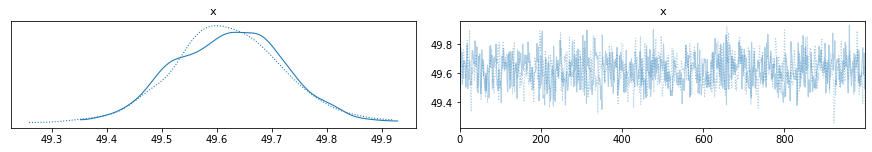

In [5]:
pm.traceplot(trace)

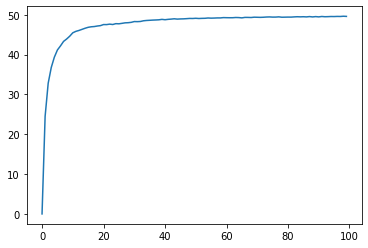

In [6]:
plt.plot(updated_mus,label='updated mean from posterior sampling of N(50,1)')

#### 2. Genrated time-changing features and choice set to check convergence of coefficients $\theta$

In [35]:
t = 0
D = 10
N = 150

# theta_0
# cov = np.random.uniform(-0.2,0.2,size=(D,D))
cov = np.zeros((D,D))
for i in range(D):
    cov[i][i]=1

# X0t
Xit = np.random.uniform(0,1,size=(N,D))

# time-changing features
wp = np.random.rand()
if wp < 0.5:
    pass
elif 0.5<= wp <0.83:
    Xit += 0.05
else:
    Xit -= 0.05
    

def posterior_sample_theta(mus,stds,observations):
    model = pm.Model()
    with model:
        mu = mus                                  # Vector of means
        cov = np.zeros((D,D))
        for i in range(D):
            cov[i][i]=stds[i]
        
        thetas = pm.MvNormal('thetas', mu=mu, cov=cov, shape=D)

        Vj = pm.math.exp(pm.math.dot(Xit,thetas))     # utility for product j
        V = 1 + pm.math.sum(Vj)                       # sum of utility, the denominator, starting with the utility of not buying
        Vit = pm.math.concatenate([[1],Vj])           # utility of no purchase = 1

        choice_prob_it = Vit/V

        choice_Y = pm.Multinomial('Customer Choice',n=1, p=choice_prob_it, observed = observations)

    with model:
        step = pm.NUTS()
        trace = pm.sample(50, step=step)

    updated_thetas_mu = pm.summary(trace)['mean'].values
    updated_thetas_std = pm.summary(trace)['sd'].values
    
    return updated_thetas_mu, updated_thetas_std, trace

In [25]:
t = [0,1]
t.extend([0 for i in range(149)])
obs = [t for i in range(100)]

In [ ]:
mus = [1 for i in range(10)]
stds = [1 for i in range(10)]

updated_mu_track = []

for i in range(100):
    wp = np.random.rand()
    if wp < 0.5:
        pass
    elif 0.5<= wp <0.83:
        Xit += 0.05
    else:
        Xit -= 0.05
    observations = obs[:i+1]
    
    updated_thetas_mu, updated_thetas_std, trace = posterior_sample_theta(mus, stds, observations)
    mus = updated_thetas_mu
    stds = updated_thetas_std
    
    updated_mu_track.append(mus)

/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb12ed10d0>,
      dtype=object)

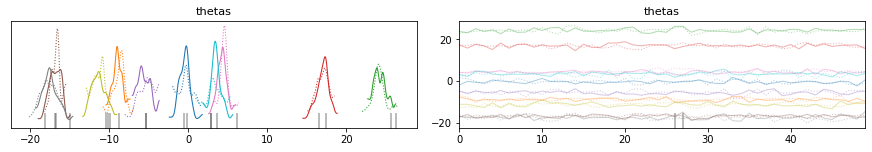

In [39]:
pm.traceplot(trace)

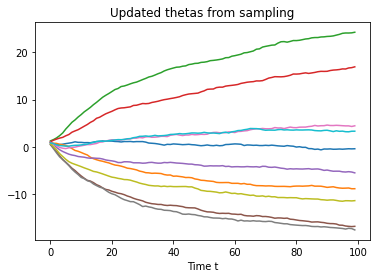

In [54]:
plt.plot(updated_mu_track)
plt.xlabel('Time t')
plt.title('Updated thetas from sampling')
plt.show()

#### 3. Changed the code, using BinaryMetropolis

I used `pm.summary()` in the previous code, which is acceptable, but not actually mcmc, as in that case, I would get the moments of $/theta$ instead of samples of theta.

So I should use the saved sample theta in `trace` and use `BinaryMetropolis` instead of NUTS, as the `y` here is binary (buy or not buy).

In [5]:
def posterior_sample_theta(mus,stds,observations,size,Xit):
    model = pm.Model()
    with model:
        mu = mus                                  # Vector of means
        cov = np.zeros((D,D))
        for i in range(D):
            cov[i][i]=stds[i]
        
        thetas = pm.MvNormal('thetas', mu=mu, cov=cov, shape=D)

        Vj = pm.math.exp(pm.math.dot(Xit,thetas))     # utility for product j
        V = 1 + pm.math.sum(Vj)                       # sum of utility, the denominator, starting with the utility of not buying
        Vit = pm.math.concatenate([[1],Vj])           # utility of no purchase = 1

        choice_prob_it = Vit/V

        choice_Y = pm.Multinomial('Customer Choice',n=1, p=choice_prob_it, observed = observations)

    with model:
        step = pm.NUTS()
        trace = pm.sample(size, step=step)

    updated_thetas_mu = pm.summary(trace)['mean'].values
    updated_thetas_std = pm.summary(trace)['sd'].values
    
    return updated_thetas_mu, updated_thetas_std, trace